# Import Libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'


# Import Databases

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
train.shape

(117626, 945)

In [4]:
#train.pivot_table(CITY, COVID_Status)

In [5]:
#Display all database


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(train.describe())

DRIVERS       PASSPORT            LAT            LON  \
count  117626.000000  117626.000000  117626.000000  117626.000000   
mean        0.984893       0.981798      42.277680     -71.359367   
std         0.121980       0.133681       0.280508       0.596881   
min         0.000000       0.000000      41.241591     -73.490615   
25%         1.000000       1.000000      42.127735     -71.547931   
50%         1.000000       1.000000      42.317179     -71.154738   
75%         1.000000       1.000000      42.456124     -71.024347   
max         1.000000       1.000000      42.901078     -69.921561   

       HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE            Age  \
count         1.176260e+05         1.176260e+05  117626.000000   
mean          1.024948e+06         3.479806e+04      55.459924   
std           5.462052e+05         8.344889e+04      18.752622   
min           5.166400e+02         0.000000e+00       0.000000   
25%           6.113264e+05         5.121200e+03      41.000000   
50%           1.170679e+06         9.262400e+03      59.000000   
75%           1.468529e+06         1.823913e+04      71.000000   
max           3.203008e+06         1.557373e+06      84.000000   

       Allergy to bee venom  Allergy to dairy product  Allergy to eggs  \
count          10872.000000              10872.000000     10872.000000   
mean               0.172553                  0.038263         0.049301   
std                0.377878                  0.191840         0.216506   
min                0.000000                  0.000000         0.000000   
25%                0.000000                  0.000000         0.000000   
50%                0.000000                  0.000000         0.000000   
75%                0.000000                  0.000000         0.000000   
max                1.000000                  1.000000         1.000000   

       Allergy to fish  Allergy to grass pollen  Allergy to mould  \
count     10872.000000             10872.000000      10872.000000   
mean          0.167770                 0.254875          0.364330   
std           0.373679                 0.435811          0.481264   
min           0.000000                 0.000000          0.000000   
25%           0.000000                 0.000000          0.000000   
50%           0.000000                 0.000000          0.000000   
75%           0.000000                 1.000000          1.000000   
max           1.000000                 1.000000          1.000000   

       Allergy to nut  Allergy to peanuts  Allergy to soya  \
count    10872.000000        10872.000000     10872.000000   
mean         0.169794            0.188466         0.016924   
std          0.375469            0.391102         0.128993   
min          0.000000            0.000000         0.000000   
25%          0.000000            0.000000         0.000000   
50%          0.000000            0.000000         0.000000   
75%          0.000000            0.000000         0.000000   
max          1.000000            1.000000         1.000000   

       Allergy to tree pollen  Allergy to wheat  Dander (animal) allergy  \
count            10872.000000      10872.000000             10872.000000   
mean                 0.252024          0.045438                 0.334989   
std                  0.434195          0.208272                 0.472008   
min                  0.000000          0.000000                 0.000000   
25%                  0.000000          0.000000                 0.000000   
50%                  0.000000          0.000000                 0.000000   
75%                  1.000000          0.000000                 1.000000   
max                  1.000000          1.000000                 1.000000   

       House dust mite allergy  Latex allergy  Shellfish allergy  \
count             10872.000000   10872.000000       10872.000000   
mean                  0.249264       0.068893           0.327539   
std                   0.432607       0.253283           0.4

In [7]:
#save oof
oof_df = train[["Id", "COVID_Status"]]

# Hyperparameters

In [8]:
seed = 42
#Using the parameters from ICU mortality 

param = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }  

In [9]:
train.drop(columns=['Death', 'Hospitalized', 'Ventilator', 'ICU', 
                    'Id', 'Days_hospitalized', 'Days_ICU', 'COVID_Status'], inplace=True)  

In [10]:
test.drop(columns=['Id'], inplace=True)

In [11]:
predictors_int = list(train.columns)

In [12]:
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [13]:
predictors_int.remove('DRIVERS')
predictors_int.remove('PASSPORT')
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')


# Creation of Dummies and missing values handling

In [14]:
train['is_train'] = 1
test['is_train'] = 0
train_test= pd.concat([train,test], axis = 0, sort=False)
train_test

,DRIVERS,PASSPORT,MARITAL,RACE,ETHNICITY,GENDER,COUNTY,LAT,LON,HEALTHCARE_EXPENSES,...,Recurrent rectal polyp_y,Rupture of patellar tendon_y.1,Secondary malignant neoplasm of colon_y.1,Streptococcal sore throat (disorder),Stroke_y.1,Suicidal deliberate poisoning_y.1,Suspected lung cancer (situation),Third degree burn_y.1,Tubal pregnancy,is_train
0,0,0,NaN,white,nonhispanic,M,Middlesex County,42.398277,-71.289383,6520.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,1,NaN,asian,hispanic,M,Middlesex County,42.691016,-71.275475,545777.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1,1,M,white,nonhispanic,M,Hampden County,42.174484,-72.784777,1039005.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,1,M,white,nonhispanic,F,Middlesex County,42.460402,-71.113293,878157.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1,1,S,white,nonhispanic,M,Middlesex County,42.338808,-71.341510,21147.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,1,1,M,white,nonhispanic,F,Worcester County,42.010525,-71.622337,746790.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,1,1,NaN,black,nonhispanic,M,Suffolk County,42.377211,-70.996938,620087.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,1,1,M,white,hispanic,F,Suffolk County,42.350963,-71.133840,32286.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,1,1,S,white,nonhispanic,M,Hampshire County,42.396915,-72.728120,989352.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,1,1,M,white,nonhispanic,M,Plymouth County,41.868198,-70.905575,823563.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [15]:
print(train.shape)
test.shape

(117626, 938)


(29492, 938)

In [16]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [17]:
predictors = list(train_test.columns)
#predictors.remove('encounter_id')
predictors.remove('is_train')

# Training Loop

In [18]:
train_test.describe()

,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Age,Allergy to bee venom,Allergy to dairy product,Allergy to eggs,Allergy to fish,Allergy to grass pollen,...,PLACE_BIRTH_PL,PLACE_BIRTH_PR,PLACE_BIRTH_PT,PLACE_BIRTH_RU,PLACE_BIRTH_SA,PLACE_BIRTH_SV,PLACE_BIRTH_US,PLACE_BIRTH_VE,PLACE_BIRTH_VN,PLACE_BIRTH_nan
count,147118.000000,147118.000000,1.471180e+05,1.471180e+05,147118.000000,13698.000000,13698.000000,13698.000000,13698.000000,13698.000000,...,147118.000000,147118.000000,147118.000000,147118.000000,147118.000000,147118.000000,147118.000000,147118.000000,147118.000000,147118.0
mean,42.277797,-71.359657,1.025151e+06,3.488275e+04,55.434733,0.172507,0.037816,0.049715,0.167616,0.257337,...,0.000924,0.010339,0.000693,0.002263,0.000068,0.001890,0.907788,0.002100,0.004309,0.0
std,0.280359,0.597374,5.462551e+05,8.423954e+04,18.793786,0.377834,0.190757,0.217364,0.373538,0.437183,...,0.030390,0.101152,0.026322,0.047522,0.008244,0.043429,0.289326,0.045782,0.065505,0.0
min,41.241591,-73.490615,5.166400e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,42.127724,-71.548354,6.106300e+05,5.117840e+03,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
50%,42.317332,-71.154619,1.169903e+06,9.262725e+03,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,42.456633,-71.024213,1.468771e+06,1.824090e+04,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
max,42.901078,-69.921561,3.203008e+06,1.595563e+06,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [19]:
from sklearn.model_selection import KFold
nfold = 5
target = 'is_train'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_test))
#predictions = np.zeros(len(test))

In [20]:

i = 1

for train_index, valid_index in skf.split(train_test, train_test.is_train.values):
    print("\nfold {}".format(i))
    
    #Train data
    t=train_test.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train_test.iloc[valid_index][predictors].values,
                           label=train_test.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 50000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100)  #1000
    oof[valid_index] = clf.predict(train_test.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    #predictions += clf.predict(test, num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[123]	training's auc: 0.751121	valid_1's auc: 0.509662

fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.527987	valid_1's auc: 0.502785

fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	training's auc: 0.625678	valid_1's auc: 0.504287

fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	training's auc: 0.672845	valid_1's auc: 0.504607

fold 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[382]	training's auc: 0.870877	valid_1's auc: 0.511096


In [21]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train_test.is_train.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train_test.is_train.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train_test.is_train.values.astype(bool), oof) -1))




CV AUC: 0.50655


CV log loss: 0.50247


CV Gini: 0.01309


In [22]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.5))

              precision    recall  f1-score   support

       False       0.27      0.00      0.00     29492
        True       0.80      1.00      0.89    117626

    accuracy                           0.80    147118
   macro avg       0.54      0.50      0.44    147118
weighted avg       0.69      0.80      0.71    147118



In [23]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.1))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29492
        True       0.80      1.00      0.89    117626

    accuracy                           0.80    147118
   macro avg       0.40      0.50      0.44    147118
weighted avg       0.64      0.80      0.71    147118



/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.05))

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29492
        True       0.80      1.00      0.89    117626

    accuracy                           0.80    147118
   macro avg       0.40      0.50      0.44    147118
weighted avg       0.64      0.80      0.71    147118



# Explainability

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [26]:
fpr_rf, tpr_rf, _ = roc_curve(train_test.is_train.values.astype(bool), oof)

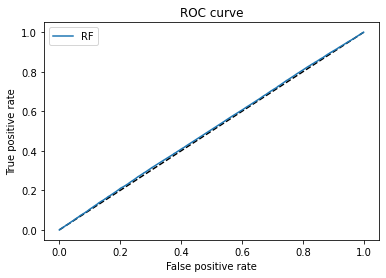

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [28]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(train_test.is_train.values.astype(bool), oof)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.80


In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [30]:
#https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#simple-xgboost-classifier

In [31]:
import seaborn as sns

In [32]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [33]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

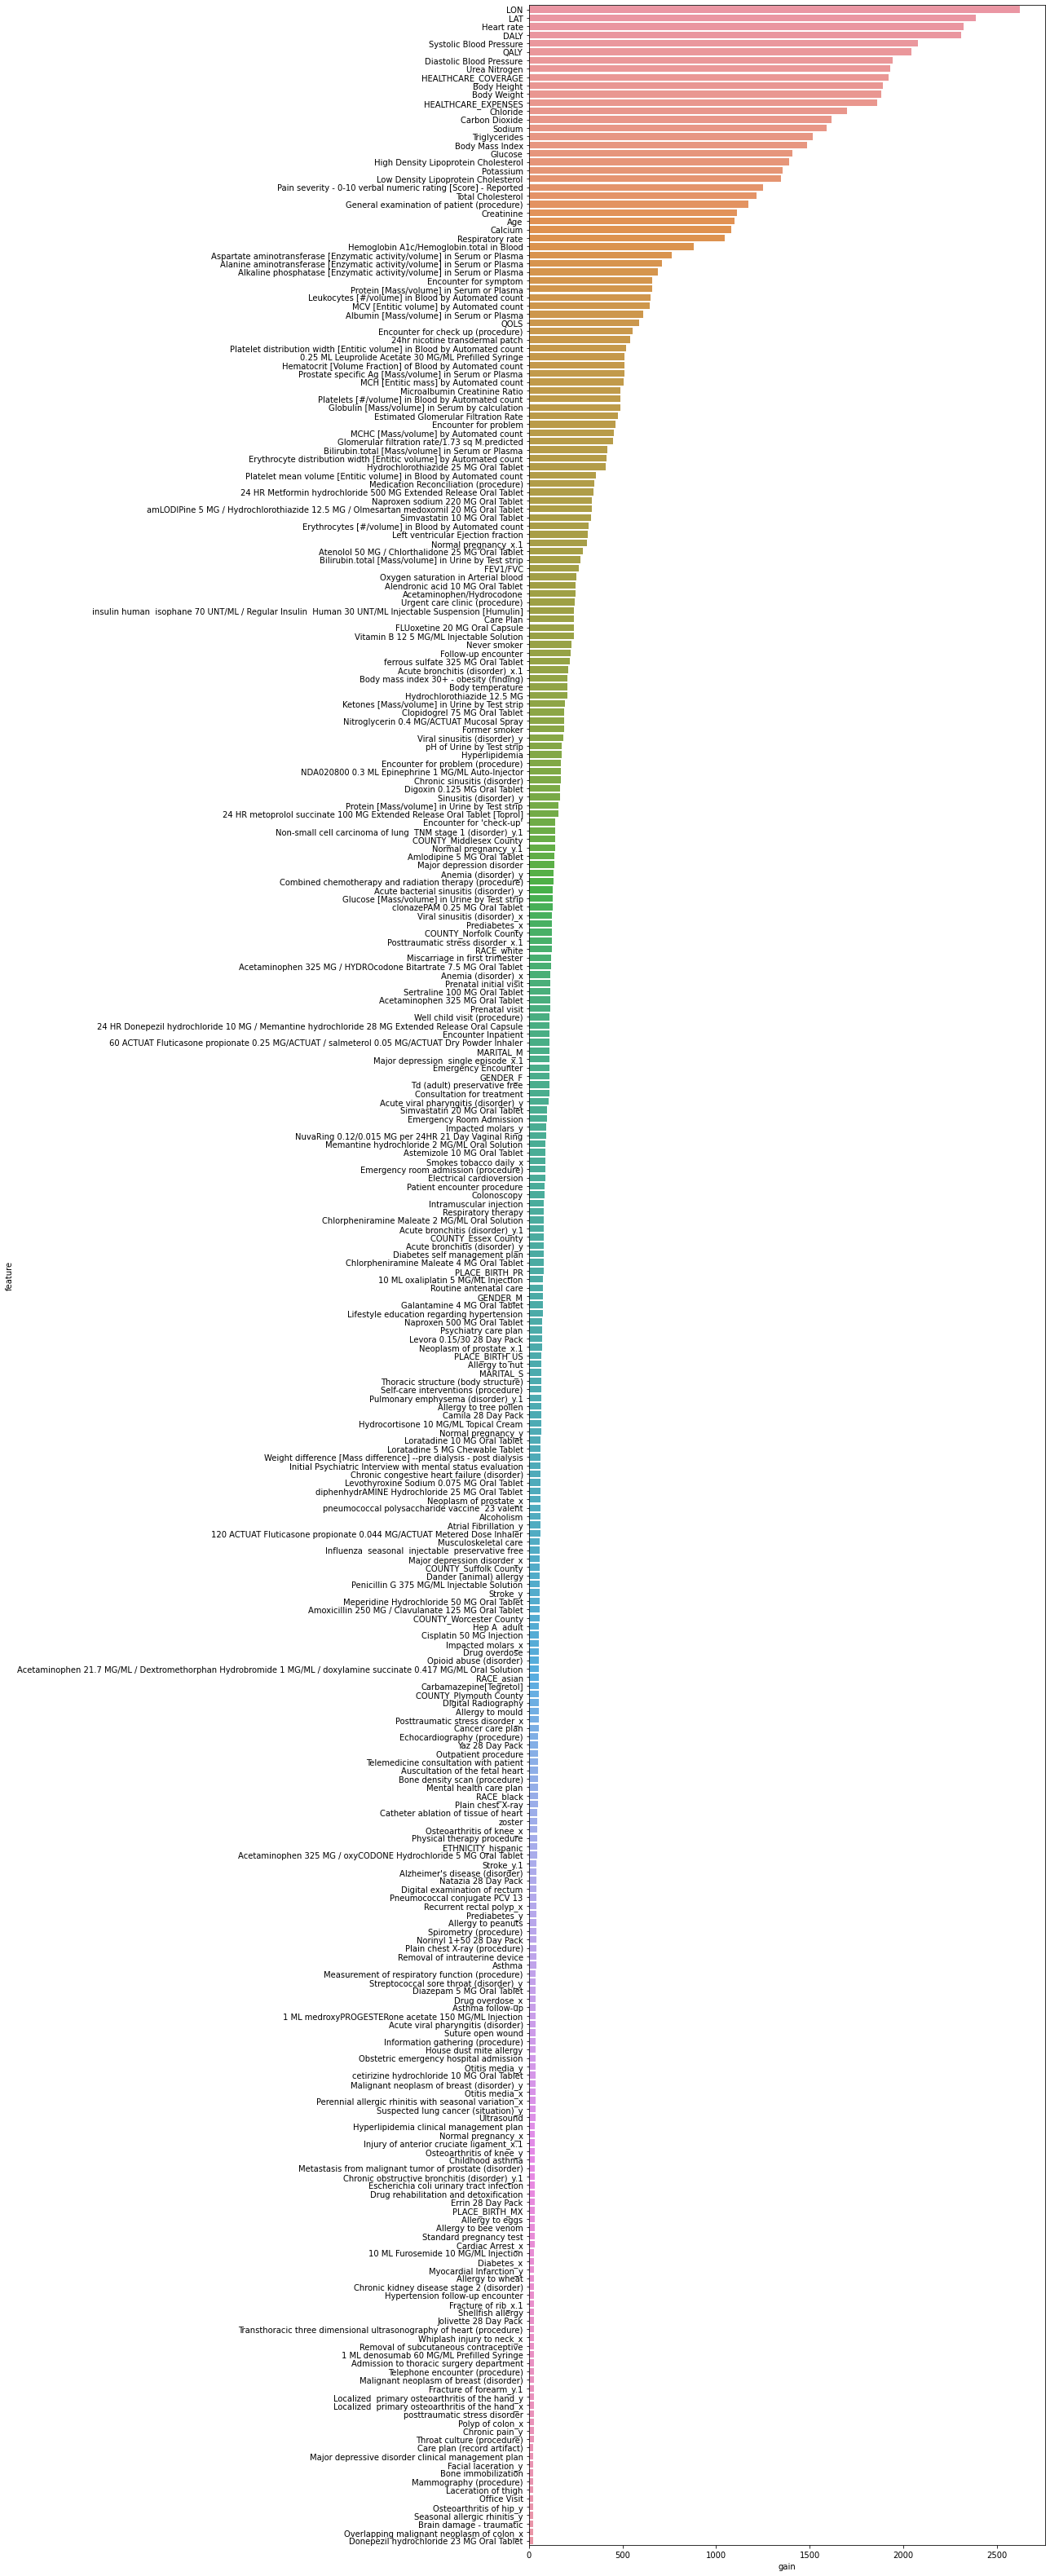

In [34]:
plot_importances(imp_df)